Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable

import utils
from model import create_model

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

dim_div_by = 64
dtype = torch.cuda.FloatTensor

# Choose figure

In [2]:
# Amphithether
img_path  = 'data/inpainting/students.jpg'
mask_path_no_student = 'data/inpainting/no_student.jpg'
mask_path_no_student_head = 'data/inpainting/no_student_head.jpg'

# Load mask

In [56]:
img_pil = utils.get_image(img_path)
img_mask_pil = utils.get_image(mask_path_no_student_head)

### Center crop

In [57]:
img_mask_pil = utils.crop_image(img_mask_pil, dim_div_by)
img_pil      = utils.crop_image(img_pil, dim_div_by)

img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)

### Visualize

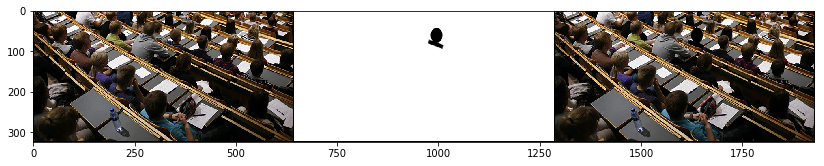

In [58]:
img_mask_var = utils.np_to_var(img_mask_np).type(dtype)

utils.plot_image_grid([img_np, img_mask_np, img_mask_np * img_np],3, 11);

# Setup

In [65]:
pad = 'zero'
OPTIMIZER = 'adam'

INPUT = 'noise'
input_depth = 8
LR = 0.1 
num_iter = 3001
param_noise = False
show_every = 500
figsize = 5

In [66]:
net = create_model(downsample_channels = [16, 32, 64, 128, 128, 128],
                   upsample_channels = [16, 32, 64, 128, 128, 128],
                   skip_channels = [0, 0, 0, 0, 0, 0],
                   input_channel_size = input_depth,
                   output_channel_size = img_np.shape[0],
                   filter_size_up=3,
                   filter_size_down=5,
                   filter_size_skip=1,
                   upsample_mode='nearest',
                   need1x1=False,
                   padding_type=pad, 
                   activation_function=nn.LeakyReLU(0.2, inplace=True)
                ).type(dtype)

LR = 0.01
net = net.type(dtype)
net_input = utils.get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

layer 0
layer 1
layer 2
layer 3
layer 4
layer 5


In [67]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 2999267


# Main loop

In [68]:
# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = utils.np_to_var(img_np).type(dtype)
mask_var = utils.np_to_var(img_mask_np).type(dtype)

i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n.data += n.data.clone().normal_()*n.data.std()/50
    
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if i % show_every == 0:
        out_np = utils.var_to_np(out)
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

Starting optimization with ADAM


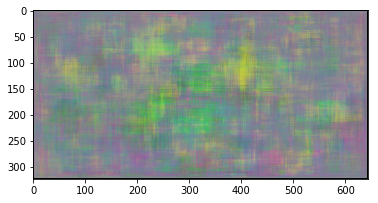

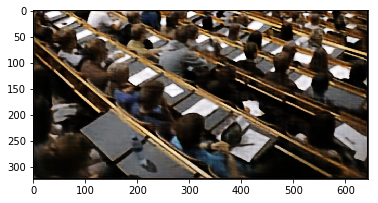

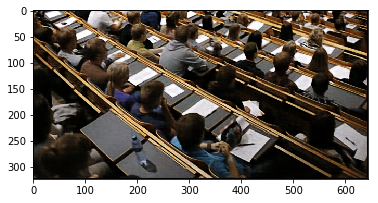

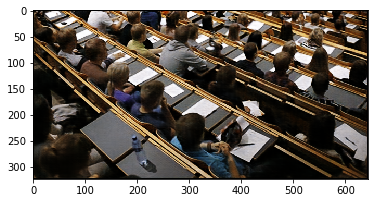

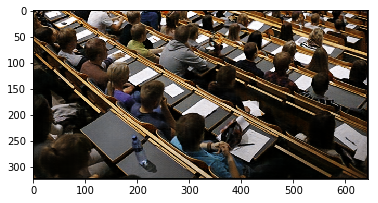

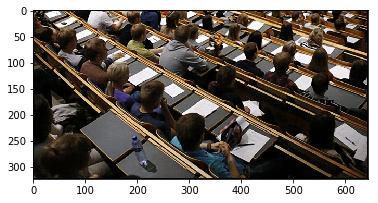

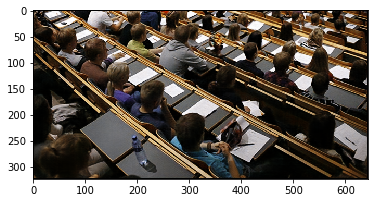

In [69]:
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
        
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

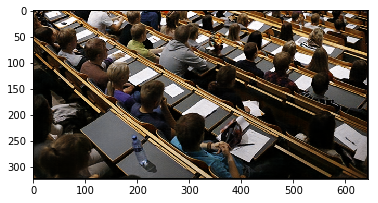

In [70]:
out_np = utils.var_to_np(net(net_input))
utils.plot_image_grid([out_np], factor=5);